# Bus AVL Project

Ehab Ebeid

## Setup

In [68]:
from __future__ import division, print_function
import numpy as np, pprint
from matplotlib import pyplot

## Data Exploration

The dataset can be very large. First, set the parameters used to specify which data to import.

In [2]:
# minimum and maximum trip start datetime, in the format "yyyy-mm-dd hh:mi:ss", local time
FROM_DT = '2018-06-13 10:00:00'
TO_DT   = '2018-06-13 12:00:00'

# a single route pattern, which encodes the bus route and direction
ROUTE_PATTERN = '7901'

The AVL data is located in a local Microsoft SQL Server database. Connect to the database and import a selection of the data using the parameters above.

In [3]:
import pyodbc 
import pandas as pd

def get_data(from_dt, to_dt, route_pattern):
    # connect to local database
    cnxn = pyodbc.connect(Trusted_Connection='yes', 
                          driver = '{SQL Server}',
                          server = 'EHAB\SQLEXPRESS', 
                          database = 'raw_nav')
    
    # join the tables route_run and gps_reading, using the filters specified above
    query = """select 
                r.id as route_run_id,
                r.route_pattern,
                r.bus_id,
                r.svc_date,
                r.trip_start_datetime,
                g.id as gps_reading_id,
                g.lat_fixed as lat,
                g.lon_fixed as lon,
                g.heading_deg,
                g.door_state,
                g.vehicle_state,
                g.odo_feet,
                g.time_seconds,
                g.sat_count,
                g.stop_window_data,
                r.invalid

            from raw_nav.dbo.route_run as r
            join raw_nav.dbo.gps_reading as g
            on r.id = g.route_run_id

            where trip_start_datetime between '{start}' and '{end}'
              and route_pattern = '{pattern}'
            ;
            """.format(start=from_dt, end=to_dt, pattern=route_pattern)

    # grab as a pandas dataframe
    return pd.read_sql_query(query, cnxn)

        
df = get_data(FROM_DT, TO_DT, ROUTE_PATTERN)

Let's take a look!

In [4]:
# summarise the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13962 entries, 0 to 13961
Data columns (total 16 columns):
route_run_id           13962 non-null int64
route_pattern          13962 non-null object
bus_id                 13962 non-null object
svc_date               13962 non-null object
trip_start_datetime    13962 non-null datetime64[ns]
gps_reading_id         13962 non-null int64
lat                    13962 non-null float64
lon                    13962 non-null float64
heading_deg            13962 non-null int64
door_state             13962 non-null object
vehicle_state          13962 non-null object
odo_feet               13962 non-null int64
time_seconds           13962 non-null int64
sat_count              13962 non-null int64
stop_window_data       348 non-null object
invalid                13962 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(7), object(6)
memory usage: 1.7+ MB


In [5]:
# first five rows
df.head()

,route_run_id,route_pattern,bus_id,svc_date,trip_start_datetime,gps_reading_id,lat,lon,heading_deg,door_state,vehicle_state,odo_feet,time_seconds,sat_count,stop_window_data,invalid
0,46714,7901,6451,06/13/18,2018-06-13 10:12:30,64088010,38.994025,-77.030545,220,C,M,0,0,6,None,0
1,46714,7901,6451,06/13/18,2018-06-13 10:12:30,64088011,38.993985,-77.030590,199,C,M,11,1,5,None,0
2,46714,7901,6451,06/13/18,2018-06-13 10:12:30,64088012,38.993940,-77.030619,178,C,M,29,2,6,None,0
3,46714,7901,6451,06/13/18,2018-06-13 10:12:30,64088013,38.993940,-77.030619,178,C,M,30,2,6,X-1,0
4,46714,7901,6451,06/13/18,2018-06-13 10:12:30,64088014,38.993940,-77.030619,178,C,M,31,2,6,E00,0


It would be useful to see how many route runs, or trips, are included in the data.

In [6]:
ntrips = df.trip_start_datetime.unique().shape
print (ntrips)

(10,)


This is the number of trips with start times given by the parameters above.

It would be useful to plot them out as time-space diagrams. Doing so is easiest with timestamps for each GPS reading, which we are missing. Instead we have the `time_seconds` field, which is the number of seconds elapsed since the start of the trip. Let's create a `timestamp` field.

In [7]:
def add_timestamps(df):
    df['timestamp'] = df.trip_start_datetime + pd.to_timedelta(df['time_seconds'], unit='s')
    return df

df = add_timestamps(df)

df.head()

,route_run_id,route_pattern,bus_id,svc_date,trip_start_datetime,gps_reading_id,lat,lon,heading_deg,door_state,vehicle_state,odo_feet,time_seconds,sat_count,stop_window_data,invalid,timestamp
0,46714,7901,6451,06/13/18,2018-06-13 10:12:30,64088010,38.994025,-77.030545,220,C,M,0,0,6,None,0,2018-06-13 10:12:30
1,46714,7901,6451,06/13/18,2018-06-13 10:12:30,64088011,38.993985,-77.030590,199,C,M,11,1,5,None,0,2018-06-13 10:12:31
2,46714,7901,6451,06/13/18,2018-06-13 10:12:30,64088012,38.993940,-77.030619,178,C,M,29,2,6,None,0,2018-06-13 10:12:32
3,46714,7901,6451,06/13/18,2018-06-13 10:12:30,64088013,38.993940,-77.030619,178,C,M,30,2,6,X-1,0,2018-06-13 10:12:32
4,46714,7901,6451,06/13/18,2018-06-13 10:12:30,64088014,38.993940,-77.030619,178,C,M,31,2,6,E00,0,2018-06-13 10:12:32


That's more like it! Now we can plot the trips.

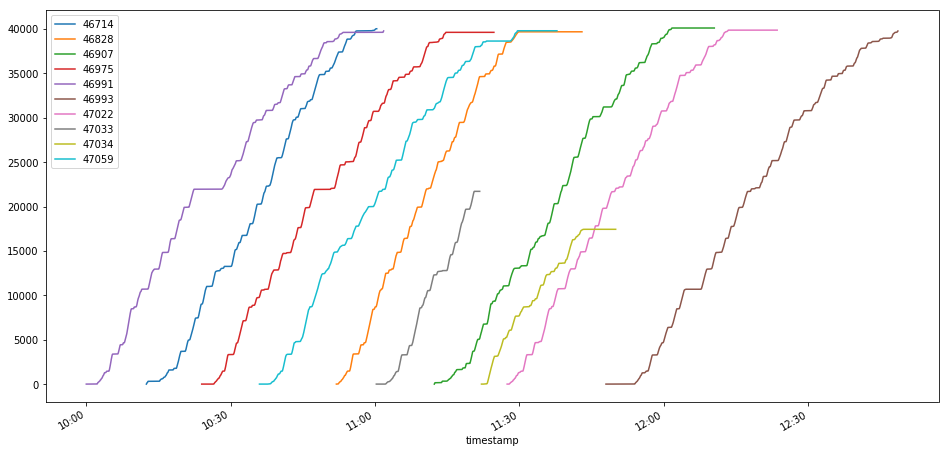

In [24]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# time-space diagrams of the trips returned
fig, ax = plt.subplots()
for name, group in df.groupby('route_run_id'):
    group.plot(x='timestamp', y='odo_feet', figsize=(16,8), ax=ax, label=name)

ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

We notice that most trips have approximately the same maximum odometer reading, at around 40,000 feet. This is to be expected since they are all on the same route and direction.

**However**, two trips stand out as erroneous: route run 47033 (grey) and 47034 (light green) are shorter than the others. Because route run 47034 starts at around the same time that 47033 ends, it is reasonable to conclude that this is a case of the bus odometer resetting to zero mid-trip. This is by far the most common case of erroneous data.

<div class='tableauPlaceholder' id='viz1546091739629' style='position: relative'><noscript><a href='#'><img alt=' ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Bu&#47;BusAVL&#47;Dashboard&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='path' value='views&#47;BusAVL&#47;Dashboard?:embed=y&amp;:display_count=y&amp;publish=yes' /> <param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Bu&#47;BusAVL&#47;Dashboard&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /><param name='filter' value='publish=yes' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1546091739629');                    var vizElement = divElement.getElementsByTagName('object')[0];                    vizElement.style.width='800px';vizElement.style.height='527px';                    var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

## Data Cleaning

### Remove trips with odometer resets to zero

In [9]:
def remove_short_trips(df):
    df_cleaned = df.copy()
    # calculate median odometer reading m
    max_odos = {}
    print("trip  max odo")
    
    for name, group in df_cleaned.groupby('route_run_id'):
        max_odo = group['odo_feet'].max()
        print(name, max_odo)
        max_odos[name] = max_odo

    max_odo_values = list(max_odos.values())
    m = np.median(max_odo_values)

    
    # mark trips with odometer readings of >1.05m or <0.95m
    for i, row in df_cleaned.iterrows():
        if max_odos[row['route_run_id']] > 1.05*m or max_odos[row['route_run_id']] < 0.95*m:
            df_cleaned.at[i,'invalid'] = 1
    
    print()
    print("Median =", m)
    
    return df_cleaned

df_cleaned = remove_short_trips(df)

trip  max odo
46714 40027
46828 39681
46907 40108
46975 39621
46991 39778
46993 39771
47022 39869
47033 21710
47034 17435
47059 39800

Median = 39774.5


In [10]:
df_cleaned.to_csv("bus_avl_cleaned.csv")

In [11]:
#TODO: Other data cleaning (?)

Let us check now if the problematic trips have been removed.

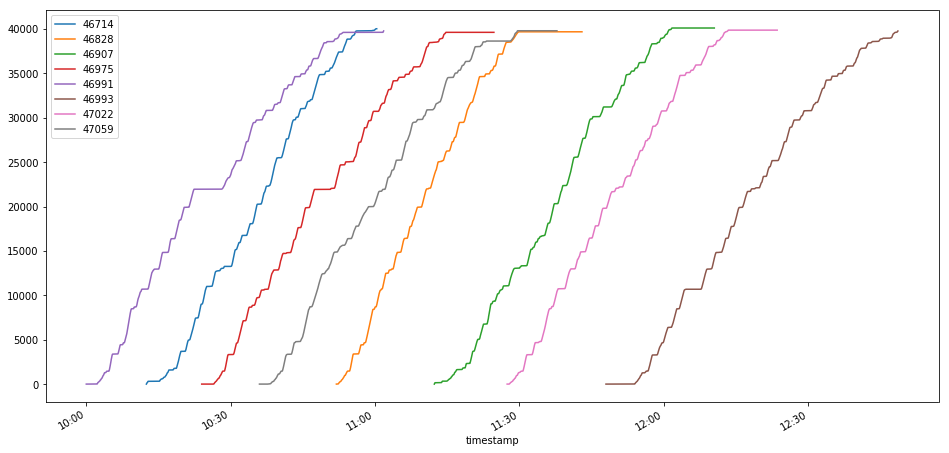

In [12]:
fig, ax = plt.subplots()
for name, group in df_cleaned.loc[df_cleaned['invalid'] == 0].groupby('route_run_id'):
    group.plot(x='timestamp', y='odo_feet', figsize=(16,8), ax=ax, label=name)

ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

Running the same steps on the entire day's data will let us know if this data cleaning task is successful.

In [18]:
FROM_DT = '2018-06-13 00:00:00' # '2018-06-13 10:00:00'
TO_DT   = '2018-06-13 23:59:59' # '2018-06-13 12:00:00'

df_all = get_data(FROM_DT, TO_DT, ROUTE_PATTERN)
df_all = add_timestamps(df_all)

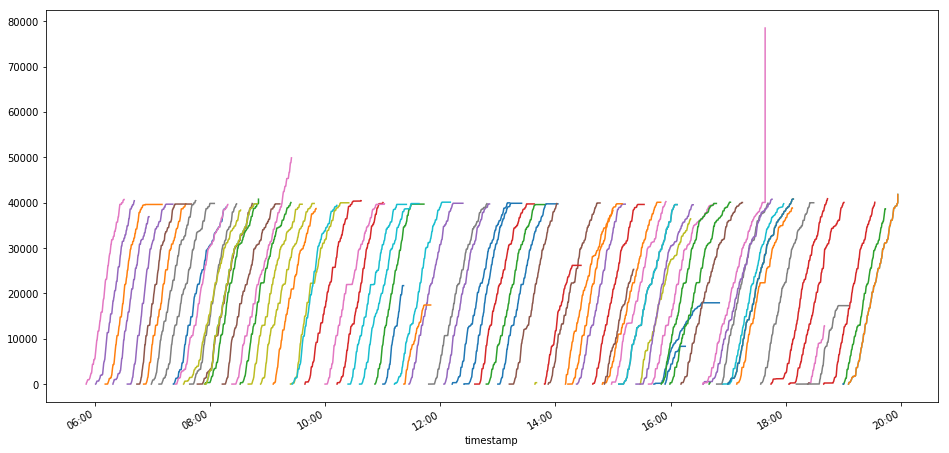

In [22]:
fig, ax = plt.subplots()
for name, group in df_all.loc[df_all['invalid'] == 0].groupby('route_run_id'):
    group.plot(x='timestamp', y='odo_feet', figsize=(16,8), ax=ax)

ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.get_legend().remove()

In [20]:
df_all_cln = remove_short_trips(df_all)

trip  max odo
46707 17925
46710 39746
46712 40035
46714 40027
46716 39716
46718 39929
46720 39664
46724 39983
46757 36444
46789 39746
46794 8328
46796 38834
46798 38649
46801 26175
46803 39540
46808 39696
46810 49883
46818 39575
46820 40806
46822 41814
46824 38953
46826 38696
46828 39681
46830 39721
46832 39675
46834 40037
46901 40697
46903 39754
46905 39975
46907 40108
46909 39739
46911 40090
46913 326
46916 40078
46936 40426
46938 39806
46965 39600
46971 40435
46973 39657
46975 39621
46977 39961
46981 38296
46983 39826
46985 40878
46987 39668
46989 39728
46991 39778
46993 39771
46995 312
46998 39767
47000 96
47016 39607
47018 40768
47020 40440
47022 39869
47024 39787
47026 40226
47028 39873
47030 38354
47031 39399
47033 21710
47034 17435
47036 39580
47038 39607
47040 40764
47043 292
47044 12839
47055 39834
47057 39824
47059 39800
47061 39867
47063 39753
47065 40096
47067 40052
47107 36907
47110 25292
47119 78509
47121 17296
47177 39746
47301 39575
47303 40806
47305 41814

Median = 39

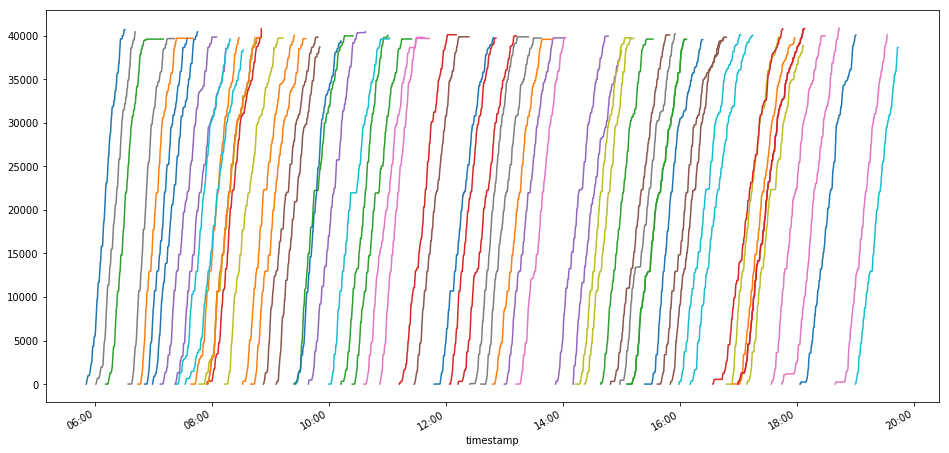

In [23]:
fig, ax = plt.subplots()
for name, group in df_all_cln.loc[df_all_cln['invalid'] == 0].groupby('route_run_id'):
    group.plot(x='timestamp', y='odo_feet', figsize=(16,8), ax=ax)

ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.get_legend().remove()

What a beauty! No more strange trips as far as I can tell.

## Analysis

In [26]:
from datetime import datetime
def ts_diff(ts1, ts2):
    """Returns diff in float minutes between
    ts1 and ts2, both in format 'yyyy-mm-dd hh:mi:ss', 
    e.g. '13/06/2018 10:12'
    """
    d1 = datetime.strptime(ts1, '%d-%m-%Y %H:%M:%S')
    d2 = datetime.strptime(ts2, '%d-%m-%Y %H:%M:%S')
    return (abs(d2-d1).total_seconds()/60)

### Segment Analysis

In [50]:
segments = {}
for name, group in df_all_cln.loc[df_all_cln['invalid'] == 0].groupby('route_run_id'):
    on = False
    segment = {}
    last_window = 0
    stationary = False
    door_open = False
    
    for i, row in group.iterrows():
        if row['stop_window_data'] == 'E02':
            # avoid start of trip
            on = True
            last_window = 2 # last window entrance code
            
        if on:
            if row['stop_window_data']:
                # segment ID
                if row['stop_window_data'][0] == 'E':
                    # entering stop window
                    last_window = int(row['stop_window_data'][1:])
                    segment_id = str(last_window)+"S"
                    
                    
                elif row['stop_window_data'][0] == 'X':
                    # exiting stop window
                    segment_id = str(last_window)+"P"
                
                if segment: # check if segment dict is not empty
                    # end previous segment
                    segment['out_ts'] = prev_row['timestamp']
                    segment['duration'] = (segment['out_ts'] - segment['in_ts']).total_seconds()
                    segment['out_odo'] = prev_row['odo_feet']
                    segment['odo_dist'] = segment['out_odo'] - segment['in_odo']
                    
                    # add segment to dict
                    if not segments.get(segment_id):
                        segments[segment_id] = []
                    segments[segment_id].append(segment)

                # start new segment
                segment = {}
                segment['in_ts'] = row['timestamp']
                segment['bus_id'] = row['bus_id']
                segment['route_run_id'] = row['route_run_id']
                segment['in_ts'] = row['timestamp']
                segment['in_odo'] = row['odo_feet']
                
            # count seconds with open door
            # TODO
            
            # count seconds with stationary vehicle
            # TODO
            
        prev_row = row

In [63]:
pp = pprint.PrettyPrinter()
# pp.pprint(segments)

segment_durations = {}
for key, segment_list in segments.items():
    for run in segment_list:
        if not segment_durations.get(key):
            segment_durations[key] = []
        segment_durations[key].append(run['duration'])

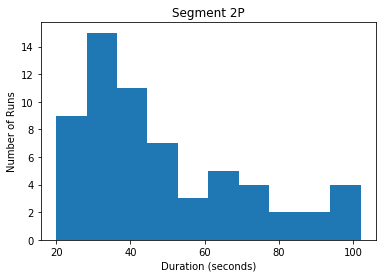

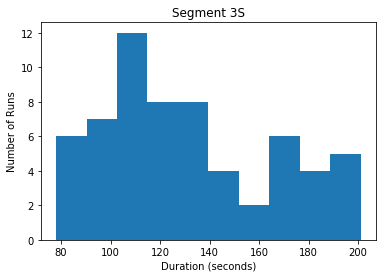

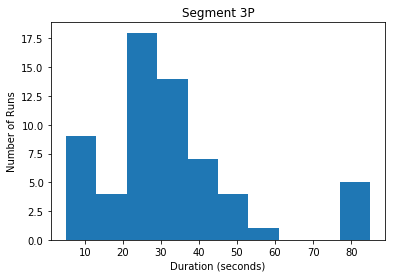

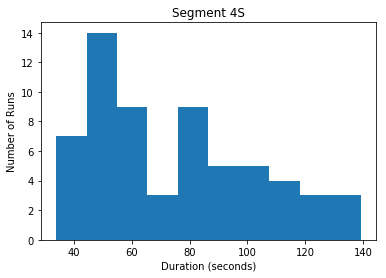

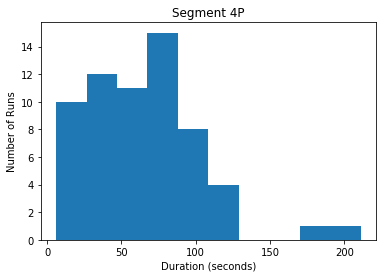

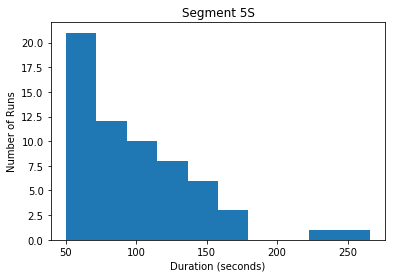

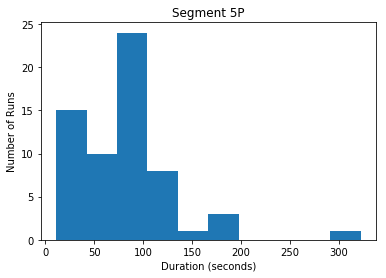

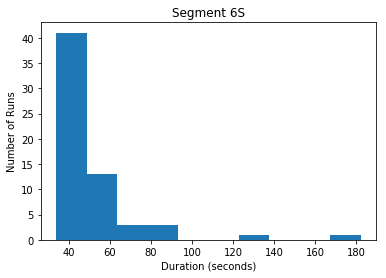

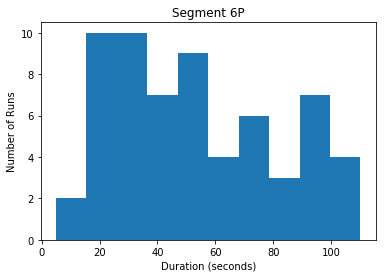

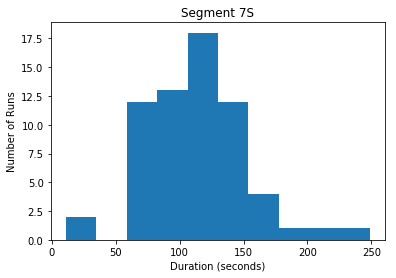

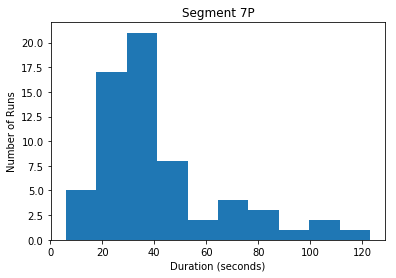

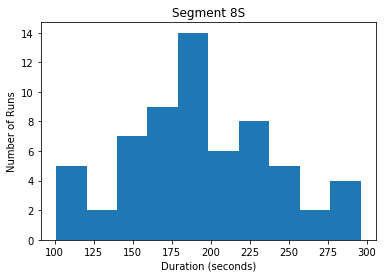

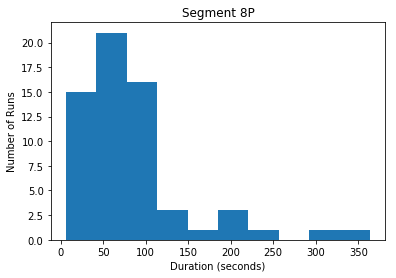

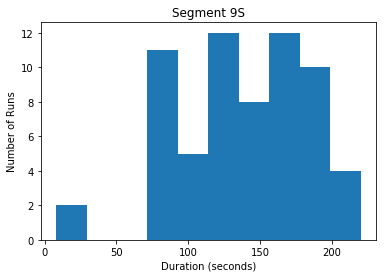

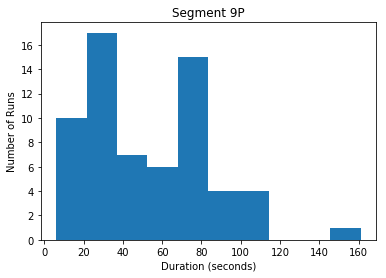

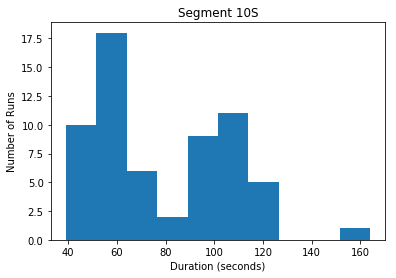

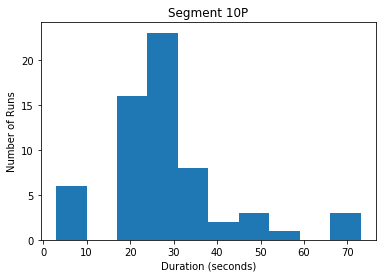

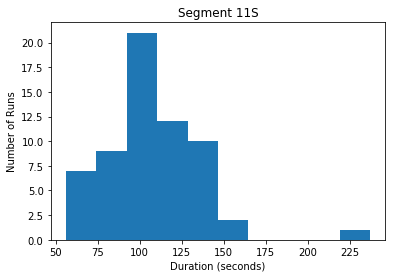

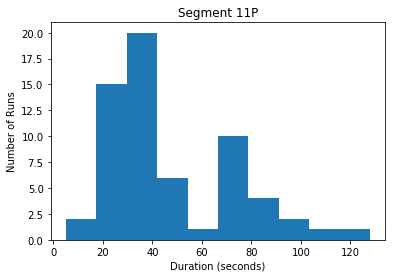

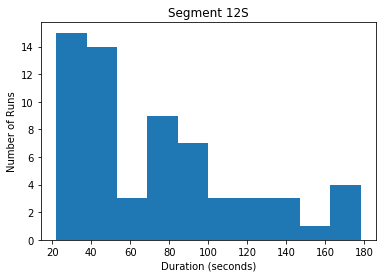

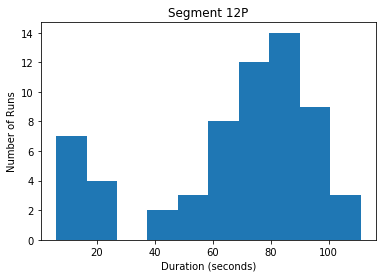

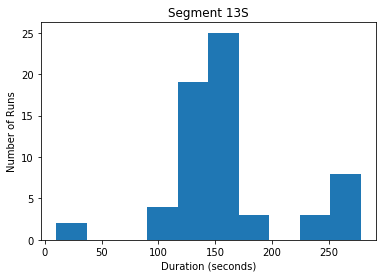

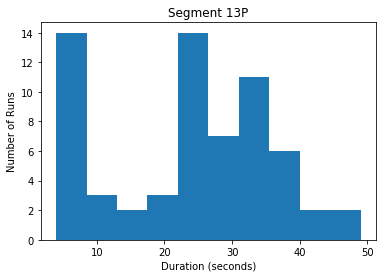

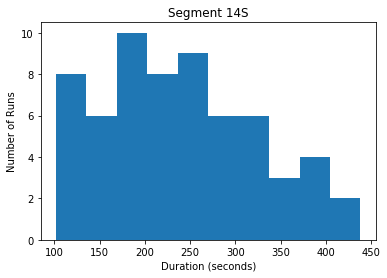

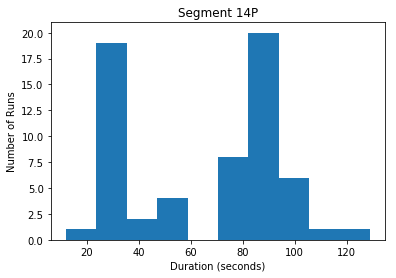

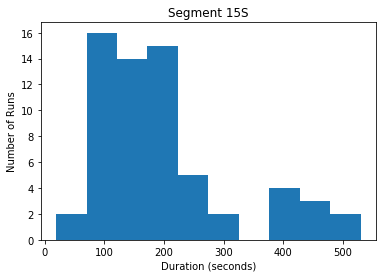

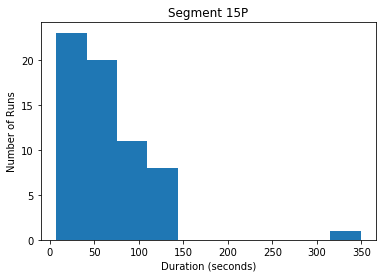

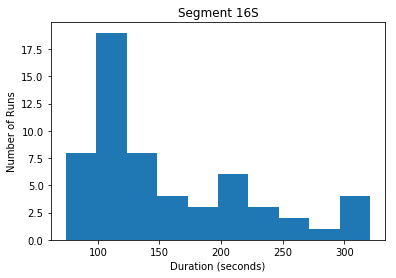

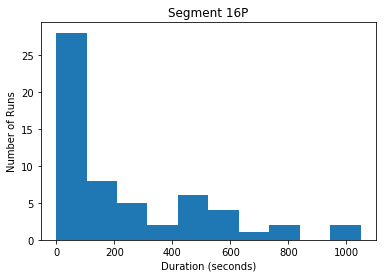

In [72]:
for key, l in segment_durations.items():
    pyplot.hist(l)
    pyplot.title("Segment "+key)
    pyplot.xlabel("Duration (seconds)")
    pyplot.ylabel("Number of Runs")
    pyplot.show()